In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from tqdm import tqdm
import numpy as np
import tensorflow as tf
from PIL import Image
import os
import pickle
import json
import cv2
import re

In [2]:
tf.test.is_gpu_available()

True

In [3]:
# make image dataloader using flow_from_dataframe
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# load data to extract labels
data_dir = '../facebook_challenge_data/'
model_dir = 'models/'

# load data and print sizes
def get_dict(path):
    jsonl_content = open(path, 'r').read()
    data = [json.loads(jline) for jline in jsonl_content.split('\n')]
    return {datum['id'] : datum for datum in data}


train_dict = get_dict(data_dir + 'train.jsonl')
val_dict = get_dict(data_dir + 'dev.jsonl')
test_dict = get_dict(data_dir + 'test.jsonl')

print(len(train_dict))
print(len(val_dict))
print(len(test_dict))

8500
500
1000


In [4]:
# custom data generator to handle cropping
# https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
from random import randint # for random cropping

class FBDataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data_dict, batch_size=32, dim=(299, 299), n_channels=3, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.data_dict = data_dict
        self.shuffle = shuffle
        
        # build labels list and id list
        self.id_list = list(self.data_dict.keys())
        self.labels = {ID: self.data_dict[ID]['label'] for ID in self.id_list}
        self.img_list = {ID: self.data_dict[ID]['img'] for ID in self.id_list}
            
        self.on_epoch_end()
        self.classes = [self.labels[self.id_list[i]] for i in self.indexes]

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.id_list) / self.batch_size)) + 1 # last batch is partial

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:index*self.batch_size + self.batch_size]
        
        
        # Find list of IDs
        id_list_temp = [self.id_list[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(id_list_temp)
        
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.id_list))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, id_list_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((len(id_list_temp), *self.dim, self.n_channels))
        y = np.empty(len(id_list_temp), dtype=int)

        # Generate data
        for i, ID in enumerate(id_list_temp):
            # Store sample
            X[i,] = self.process_img(data_dir + self.img_list[ID])

            # Store class
            y[i] = self.labels[ID]

        return X, y
    
    def process_img(self, path): # method for getting image
        img = Image.open(path)
        img.load()
        scale_size = int(2 * self.dim[0]) # want cropping
        if img.size[0] < img.size[1]: # width greater than height
            wpercent = (scale_size/float(img.size[0]))
            hsize = int((float(img.size[1])*float(wpercent)))
            img = img.resize((scale_size,hsize), Image.ANTIALIAS)
        else: # height greater than width
            hpercent = (scale_size/float(img.size[1]))
            wsize = int((float(img.size[0])*float(hpercent)))
            img = img.resize((wsize, scale_size), Image.ANTIALIAS)
            
        data = np.asarray(img, dtype='uint8')
        im = self.augment(data) # apply transformation
        
        
        if im.shape==(self.dim[0], self.dim[1]): im = np.stack((im,)*3, axis=-1) # handle grayscale
        if im.shape == (*self.dim, 4): im = im[:,:,:3] # handle weird case
        
        return im
    
    def augment(self, im): # random crop and random mirror
        
        # random crop
        x_max, y_max = im.shape[0], im.shape[1]
        x_start, y_start = randint(0, x_max - self.dim[0]), randint(0, y_max - self.dim[1])
        im = im[x_start:x_start + self.dim[0], y_start:y_start + self.dim[1]]
        
        # random mirror
        if randint(0,1): im = np.flip(im, axis=1)
        
        return im


In [5]:
# create data generators
train_gen = FBDataGenerator(data_dict=train_dict,
                          batch_size=16,
                          dim=(224, 224),
                          n_channels=3,
                          shuffle=True)

val_gen = FBDataGenerator(data_dict=val_dict,
                          batch_size=16,
                          dim=(224, 224),
                          n_channels=3,
                          shuffle=True)

In [6]:
# # test the image generator

# imgs, ys = train_gen.__getitem__(0)

# for img, y in list(zip(imgs, ys))[:10]:
#     img = Image.fromarray(np.uint8(img), 'RGB')
#     display(img)
#     print('size:', img.size, 'label:', y, '\n\n\n')

In [7]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import layers
from tensorflow.keras.models import Model

conv_base = tf.keras.applications.resnet.ResNet152(include_top=False, 
                                                        weights='imagenet', 
                                                        input_shape=(224, 224, 3))

for layer in conv_base.layers:
    if isinstance(layer, layers.BatchNormalization): layer.trainable = True
    else: layer.trainable = False


model = Sequential()
model.add(conv_base)
model.add(layers.GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())

optimizer = Adam(lr = 1e-7)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152 (Model)            (None, 7, 7, 2048)        58370944  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 60,994,433
Trainable params: 2,623,489
Non-trainable params: 58,370,944
_________________________________________________________________
None


In [8]:
# train model

# from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint

# model = load_model(model_dir + 'cnn_weighted.h5')

mcp_save = ModelCheckpoint(model_dir + 'best_fb_resnet_larger_crop.h5', 
                           save_best_only=True, 
                           monitor='val_loss', 
                           mode='min',
                           verbose=1,
                           save_weights_only=True)

history = model.fit_generator(train_gen,
                    validation_data=val_gen,
                    shuffle=True,
                    epochs=20,
                    callbacks=[mcp_save])


Epoch 1/20
531/532 [============================>.] - ETA: 1s - loss: 0.7830 - accuracy: 0.4115
Epoch 00001: val_loss improved from inf to 0.73053, saving model to models/best_fb_resnet_larger_crop.h5
532/532 [==============================] - 606s 1s/step - loss: 0.7829 - accuracy: 0.4118 - val_loss: 0.7305 - val_accuracy: 0.5040
Epoch 2/20
531/532 [============================>.] - ETA: 1s - loss: 0.7078 - accuracy: 0.5086
Epoch 00002: val_loss did not improve from 0.73053
532/532 [==============================] - 597s 1s/step - loss: 0.7078 - accuracy: 0.5088 - val_loss: 0.7467 - val_accuracy: 0.4860
Epoch 3/20
531/532 [============================>.] - ETA: 1s - loss: 0.6766 - accuracy: 0.5837
Epoch 00003: val_loss did not improve from 0.73053
532/532 [==============================] - 597s 1s/step - loss: 0.6764 - accuracy: 0.5840 - val_loss: 0.7703 - val_accuracy: 0.4960
Epoch 4/20
531/532 [============================>.] - ETA: 1s - loss: 0.6715 - accuracy: 0.6071
Epoch 00004: 

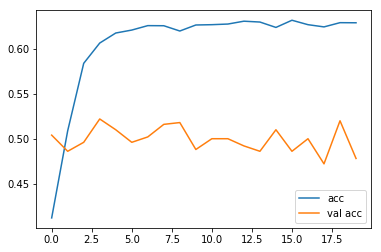

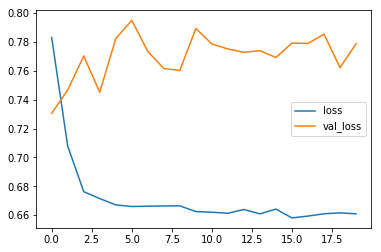

In [9]:
plt.plot(history.history['accuracy'], label = 'acc')
plt.plot(history.history['val_accuracy'], label = 'val acc')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.legend()
plt.show()

In [10]:
model.load_weights(model_dir + 'best_fb_resnet_larger_crop.h5')

In [11]:
# test
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score
import math

y_val = val_gen.classes

# get AUROC
preds = model.predict_generator(val_gen)
print('Test AUROC:', roc_auc_score(y_val, preds))

# get loss and acc
preds_bin = np.array(preds)
preds_bin[preds>0.5] = 1
preds_bin[preds<=0.5] = 0
print('Test Accuracy:', accuracy_score(y_val, preds_bin))

# get F1
print('Test F1:', f1_score(y_val, preds_bin, zero_division=1))
print('Test Precision:', precision_score(y_val, preds_bin, zero_division=1))
print('Test Recall:', recall_score(y_val, preds_bin, zero_division=1))

Test AUROC: 0.526336
Test Accuracy: 0.51
Test F1: 0.5648312611012433
Test Precision: 0.5079872204472844
Test Recall: 0.636


In [ ]:
# for im in os.listdir('../facebook_challenge_data/img/'):
#     img = Image.open('../facebook_challenge_data/img/' + im)
#     print(img.size)

In [22]:
# custom data generator to handle cropping
# https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
from random import randint # for random cropping

class FBDataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data_dict, batch_size=32, dim=(299, 299), n_channels=3, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.data_dict = data_dict
        self.shuffle = shuffle
        
        # build labels list and id list
        self.id_list = list(self.data_dict.keys())
        self.labels = {ID: self.data_dict[ID]['label'] for ID in self.id_list}
        self.img_list = {ID: self.data_dict[ID]['img'] for ID in self.id_list}
            
        self.on_epoch_end()
        self.classes = [self.labels[self.id_list[i]] for i in self.indexes]

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.id_list) / self.batch_size)) + 1 # last batch is partial

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:index*self.batch_size + self.batch_size]
        
        
        # Find list of IDs
        id_list_temp = [self.id_list[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(id_list_temp)
        
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.id_list))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, id_list_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((len(id_list_temp), *self.dim, self.n_channels))
        y = np.empty(len(id_list_temp), dtype=int)

        # Generate data
        for i, ID in enumerate(id_list_temp):
            # Store sample
            X[i,] = self.process_img(data_dir + self.img_list[ID])

            # Store class
            y[i] = self.labels[ID]

        return X, y
    
    def process_img(self, path): # method for getting image
        img = Image.open(path)
        img.load()
        img = img.resize(self.dim)
        print(img.size)
            
        data = np.asarray(img, dtype='uint8')
        im = self.augment(data) # apply transformation
        
        
        if im.shape==(self.dim[0], self.dim[1]): im = np.stack((im,)*3, axis=-1) # handle grayscale
        if im.shape == (*self.dim, 4): im = im[:,:,:3] # handle weird case
        
        return im
    
    def augment(self, im): # random crop and random mirror
        
        # random crop
        x_max, y_max = im.shape[0], im.shape[1]
        x_start, y_start = randint(0, x_max - self.dim[0]), randint(0, y_max - self.dim[1])
        im = im[x_start:x_start + self.dim[0], y_start:y_start + self.dim[1]]
        
        # random mirror
#         if randint(0,1): im = np.flip(im, axis=1)
        
        return im

    
train_gen = FBDataGenerator(data_dict=train_dict,
                          batch_size=16,
                          dim=(224, 224),
                          n_channels=3,
                          shuffle=True)

(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)


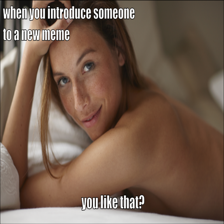

size: (224, 224) label: 0 





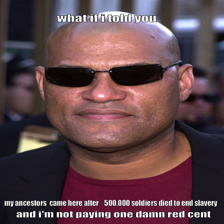

size: (224, 224) label: 0 





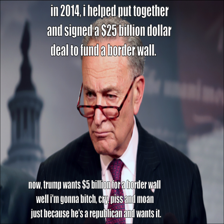

size: (224, 224) label: 0 





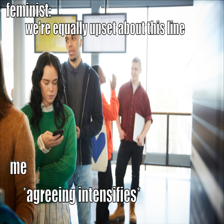

size: (224, 224) label: 0 





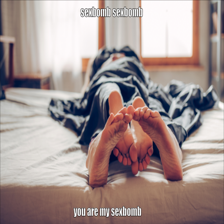

size: (224, 224) label: 0 





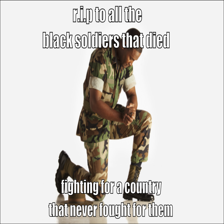

size: (224, 224) label: 0 





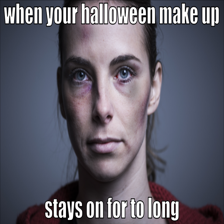

size: (224, 224) label: 0 





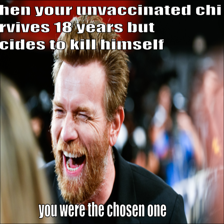

size: (224, 224) label: 0 





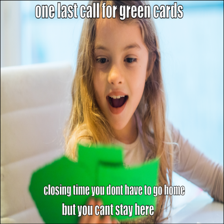

size: (224, 224) label: 0 





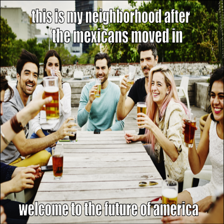

size: (224, 224) label: 0 





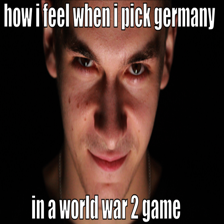

size: (224, 224) label: 0 





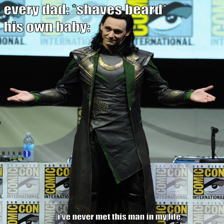

size: (224, 224) label: 0 





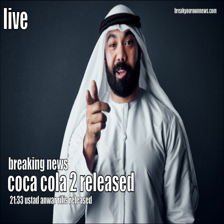

size: (224, 224) label: 0 





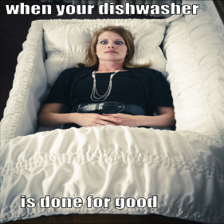

size: (224, 224) label: 1 





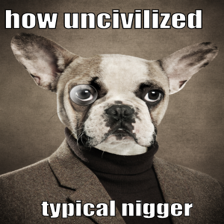

size: (224, 224) label: 1 





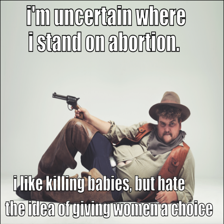

size: (224, 224) label: 1 





In [23]:
imgs, ys = train_gen.__getitem__(0)

for img, y in list(zip(imgs, ys)):
    img = Image.fromarray(np.uint8(img), 'RGB')
    display(img)
    print('size:', img.size, 'label:', y, '\n\n\n')